In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")
import time


INFO:root:test


In [2]:
from craft.craco import bl2ant

In [3]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'

# ULP1
fits = '/data/craco/ban115/craco-python/notebooks/data/SB49721/b00.uvfits'

xclbin='/data/craco/ban115/builds/binary_container_1_10688715.xclbin'
xclbin='/data/craco/ban115/builds/binary_container_fe3fef0d.xclbin'
xclbin='/data/craco/ban115/builds/binary_container_e76baa70a.xclbin'

# u280 - 2023.1
xclbin='/data/craco/ban115/builds/binary_container_1_3b3cceff9_2023.1.xclbin'

alloc_device_only=True

In [4]:
values = craco.search_pipeline.get_parser().parse_args([])
print(values)

Namespace(boxcar_weight='sum', calibration=None, cand_file='candidates.txt', cell=None, device=0, dflag_fradius=0, dflag_tblk=None, dflag_threshold=0, dflag_tradius=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_input=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=0, flag_ants=[], flag_chans=None, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', outdir='.', phase_center_filterbank=None, print_dm0_stats=False, run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, skip_blocks=0, subtract=256, target_input_rms=512, threshold=10.0, uv=None, verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [5]:
xbin = pyxrt.xclbin(xclbin)
device = pyxrt.device(0)
uuid = device.load_xclbin(xbin)


In [6]:
f = uvfits.open(fits, skip_blocks=1000)


INFO:root:Opening file /data/craco/ban115/craco-python/notebooks/data/SB49721/b00.uvfits


In [7]:
f.hdulist[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    7                                                  
NAXIS1  =                    0 / Random axis group                              
NAXIS2  =                    3                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                  120                                                  
NAXIS5  =                    1                                                  
NAXIS6  =                    1                                                  
NAXIS7  =                    1                                                  
EXTEND  =                    T / Tables will follow                             
BLOCKED =                    T / File may be blocked                            
GROUPS  =                   

In [8]:
for blid, v in f.baselines.items():
    #total = np.sqrt(sum(v**2))
    uvw = np.array([v['UU'], v['VV'], v['WW']])
    uvdist = sum(uvw**2)
    if uvdist > 1e-5:
        print(blid, bl2ant(blid), uvdist)


2333.0 (9, 29) 0.0004520773
2573.0 (10, 13) 0.00045207702
2574.0 (10, 14) 0.00045207702
2575.0 (10, 15) 0.00045207702
2589.0 (10, 29) 0.00045207702
2829.0 (11, 13) 0.0004520769
2830.0 (11, 14) 0.0004520769
2831.0 (11, 15) 0.0004520769
2845.0 (11, 29) 0.0004520769
3085.0 (12, 13) 0.00045207696
3086.0 (12, 14) 0.00045207696
3087.0 (12, 15) 0.00045207696
3101.0 (12, 29) 0.00045207696
3344.0 (13, 16) 0.00045207684
3345.0 (13, 17) 0.00045207678
3346.0 (13, 18) 0.00045207693
3347.0 (13, 19) 0.00045207684
3348.0 (13, 20) 0.00045207696
3349.0 (13, 21) 0.00045207693
3350.0 (13, 22) 0.00045207675
3351.0 (13, 23) 0.000452077
3352.0 (13, 24) 0.00045207707
3353.0 (13, 25) 0.0004520769
3354.0 (13, 26) 0.0004520767
3355.0 (13, 27) 0.00045207655
3356.0 (13, 28) 0.0004520766
3358.0 (13, 30) 0.00045207707
3600.0 (14, 16) 0.00045207684
3601.0 (14, 17) 0.00045207678
3602.0 (14, 18) 0.00045207693
3603.0 (14, 19) 0.00045207684
3604.0 (14, 20) 0.00045207696
3605.0 (14, 21) 0.00045207693
3606.0 (14, 22) 0.000

<IPython.core.display.Javascript object>


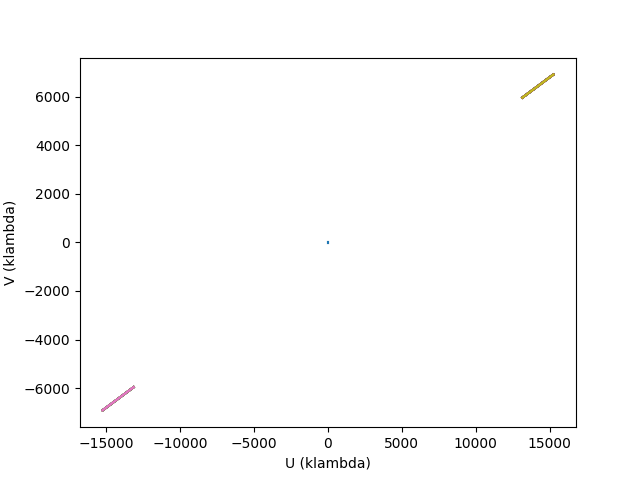

In [9]:
f.plot_baselines()

In [10]:
plan = PipelinePlan(f, "--ndm 512 --flag-ants 10-15,29")

INFO:craft.craco_plan:Unknown beamid
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', calibration=None, cell=None, dflag_fradius=0, dflag_tblk=None, dflag_threshold=0, dflag_tradius=0, fdmt_scale=1.0, fft_scale=10.0, flag_ants=[10, 11, 12, 13, 14, 15, 29], max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, target_input_rms=512, threshold=3, uv='uv_data', verbose=False) prev plan:None
/data/craco/ban115/craft-github/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'CRACO_ULP1', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 279.76186254582103, -10.530108502715647, 2000.0, 279.76186254582103, -10.530108502715647, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targ

parsing values --ndm 512 --flag-ants 10-15,29


INFO:craft.craco_plan:Nbl=99 Fch1=743990740.740741 foff=1000000.000000 nchan=120 lambdamin=0.347628 uvmax=(3503.2736668991092, 5798.916607036347) max baseline=(1.217837052536197, 2.015867494264967) resolution=[58.87773148 35.56954173]arcsec uvcell=[28.03701499 16.93787701] arcsec uvcell= (28.737791798781757, 47.56923779209504) lambda FoV=[1.99374329 1.20447125] deg oversampled=(2.1, 2.1) wcs=WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 279.76186254582103  -10.530108502715647  
CRPIX : 129.0  129.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.007788059719065317  0.004704965837400287  
NAXIS : 0  0
/data/craco/ban115/craft-github/src/craft/craco_plan.py:150: UserWarning: Cannot grid things on U=0 or V=0 blid=4380.0 17-28 uvpix=(0, 217)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:150: UserWarning: Cannot grid things on U=0 or V=0 blid=438

In [11]:
print(plan.ndout)

186


In [12]:
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

Opening kernel with new name krnl_ddgrid_reader_4cu
Kernel krnl_ddgrid_reader_4cu has groups
GID=0=32
GID=1=65535
GID=2=65535
GID=3=65535
GID=4=65535
GID=5=15
Opening kernel with new name krnl_grid_4cu:{krnl_grid_4cu_1}
Kernel krnl_grid_4cu:{krnl_grid_4cu_1} has groups
GID=0=131071
GID=1=131071
GID=2=131071
GID=3=131071
GID=4=131071
GID=5=65542
Opening kernel with new name krnl_grid_4cu:{krnl_grid_4cu_2}
Kernel krnl_grid_4cu:{krnl_grid_4cu_2} has groups
GID=0=196607
GID=1=196607
GID=2=196607
GID=3=196607
GID=4=196607
GID=5=131079
Opening kernel with new name krnl_grid_4cu:{krnl_grid_4cu_3}
Kernel krnl_grid_4cu:{krnl_grid_4cu_3} has groups
GID=0=262143
GID=1=262143
GID=2=262143
GID=3=262143
GID=4=262143
GID=5=196628
Opening kernel with new name krnl_grid_4cu:{krnl_grid_4cu_4}
Kernel krnl_grid_4cu:{krnl_grid_4cu_4} has groups
GID=0=327679
GID=1=327679
GID=2=327679
GID=3=327679
GID=4=327679
GID=5=262165
Opening kernel with new name fft2d:{fft2d_1}
Kernel fft2d:{fft2d_1} has groups
Opening

INFO:craco.search_pipeline:Allocating FDMT Input
INFO:craco.pyxrtutil:Allocated 268435456 bytes flags=flags.normal groupid=655413 address=0x90000000
INFO:craco.search_pipeline:FDMT input buffer size 256.0 MB
INFO:craco.search_pipeline:Allocating FDMT history
INFO:craco.pyxrtutil:Allocated 268435456 bytes flags=flags.normal groupid=655414 address=0xa0000000


Kernel krnl_boxc_4cu has groups
GID=0=655359
GID=1=655359
GID=2=655359
GID=3=589879
GID=4=589879
GID=5=589828
Opening kernel with new name fdmt_tunable_c32
Kernel fdmt_tunable_c32 has groups
GID=0=655413
GID=1=655392
GID=2=655414
GID=3=655414
GID=4=655374


/data/craco/ban115/craco-python/src/craco/search_pipeline.py:321: UserWarning: Expected fdmt output to be grid reader input. FDMTout = 655392 != grid reader 32. Perhaps it isnt imporant anymore
  warnings.warn(f'Expected fdmt output to be grid reader input. FDMTout = {self.fdmtcu.group_id(1)} != grid reader { self.grid_reader.group_id(0)}. Perhaps it isnt imporant anymore')
INFO:craco.search_pipeline:Allocating mainbuf
INFO:craco.search_pipeline:FDMT output buffer size 15.984375 GB
INFO:craft.fdmt_plan:Started with 1065 cells which would need at least 134 runs
INFO:craft.fdmt_plan:With 5 channels at [  0  32  64  96 128] we needed 169 runs. An increase of 1.261 
INFO:craft.fdmt_plan:Creating FdmtPlan for 1065 cells plan=<craft.craco_plan.PipelinePlan object at 0x7f75c02fecf8> prev_plan=None We have 169 initial runs
INFO:craft.fdmt_plan:Found zero cell among runs: (87, 3)
INFO:craft.fdmt_plan:FDMT zero cell is (87, 3)=699
INFO:craft.fdmt_plan:FDMT plan has ntotal=1352 of 169 runs with p

# New version of clear buffers

In [13]:
#sp=fdmt_tunable_c32_1.pin:HBM[9:13]
#sp=fdmt_tunable_c32_1.pout:DDR[0]
#sp=fdmt_tunable_c32_1.histin:HBM[10:13]
#sp=fdmt_tunable_c32_1.histout:HBM[10:13]
#sp=fdmt_tunable_c32_1.pconfig:HBM[14]

p.fdmtcu.groups
# group 2 and 3 are the histin, and histout which are HBM[10:13]

[655413, 655392, 655414, 655414, 655374]

In [14]:
nbytes = 256*1024*1024
buf = pyxrt.bo(device, nbytes, pyxrt.bo.flags.normal, p.fdmtcu.groups[2])
buf2 = pyxrt.bo(device, nbytes, pyxrt.bo.flags.normal, p.fdmtcu.groups[2])

In [15]:
dir(buf)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'address',
 'cacheable',
 'device_only',
 'flags',
 'host_only',
 'map',
 'normal',
 'p2p',
 'read',
 'size',
 'svm',
 'sync',
 'write']

In [16]:
buf.address()

2952790016

In [17]:
buf2.address()

3221225472

In [33]:
assert buf2.address() == buf.address() + buf.size()

# Let's put a 0 DM pulse in the last few samples of mainbuf so we can see what it looks like in the boxcar history

In [18]:
p.clear_buffers(values)
# dmamp = 32 gives SNR=14.2
dmamp = 16*16
t0 = 252 # If I make t0=between 255-NBOX (-1?) and 255 I should see it in the boxcar history
dm = 0

# put in a value for a single time and DM
for b in p.all_mainbufs:
    print(b.shape)
    #b.nparr[:] = dmamp #np.random.randn(*b.nparr.shape)
    #b.nparr[:] = dmamp
    b.nparr[:,dm,0,t0,:,0] = dmamp
    b.copy_to_device() 

INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


[22, 186, 11, 256, 8, 2]
[22, 186, 11, 256, 8, 2]
[22, 186, 11, 256, 8, 2]
[22, 186, 11, 256, 8, 2]
[22, 186, 11, 256, 8, 2]
[22, 186, 11, 256, 8, 2]
[22, 186, 11, 256, 8, 2]
[22, 186, 11, 256, 8, 2]


In [19]:
check_mainbuf = False

if check_mainbuf:
    mainbuf = p.copy_mainbuf()
    print(mainbuf.shape)
    plot(mainbuf[:,0,0,t0,:,0].flat)
    assert np.all(mainbuf[:,0,0,t0,:,0] == dmamp)
    assert np.all(mainbuf[:,1:,1:,:t0,:,1] == 0)
    assert np.all(mainbuf[:,1:,1:,:t0+1,:,1] == 0)
    print(mainbuf.sum())

In [20]:
values.run_fdmt = False
values.run_image = True
values.threshold = 10
values.subtract = False
print(values)
p.run(0, values).wait()

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=1352 nparallel_uv=676 nurest=169 load_luts=1 nplane=16384 shift1=0 shift2=0 fft_cfg=40000000 threshold=10 imgnoise=54.49770637375485 bcnoise=13.624426593438713 bcthresh=136.24426593438713=136

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts


Namespace(boxcar_weight='sum', calibration=None, cand_file='candidates.txt', cell=None, device=0, dflag_fradius=0, dflag_tblk=None, dflag_threshold=0, dflag_tradius=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_input=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=0, flag_ants=[], flag_chans=None, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', outdir='.', phase_center_filterbank=None, print_dm0_stats=False, run_fdmt=False, run_image=True, show=False, show_candidate_grid=None, skip_blocks=0, subtract=False, target_input_rms=512, threshold=10, uv=None, verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [21]:
mainbuf = p.copy_mainbuf()

In [22]:
cands = p.get_candidates()
print(f'Got {len(cands)} candidates')
if len(cands) == 0: # are you sure?
    p.candidates.copy_from_device()
    print(p.candidates.nparr)
    
print_candidates(cands, 256, 0)
print("The sume all the mainbufs was", mainbuf.sum())

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 0 candidates
[(0, 0, 0, 0, 0) (0, 0, 0, 0, 0) (0, 0, 0, 0, 0) ... (0, 0, 0, 0, 0)
 (0, 0, 0, 0, 0) (0, 0, 0, 0, 0)]
# SNR	lpix	mpix	boxc_width	time	dm	iblk	rawsn

The sume all the mainbufs was 360448


In [23]:
p.boxcar_history.copy_from_device()

<IPython.core.display.Javascript object>


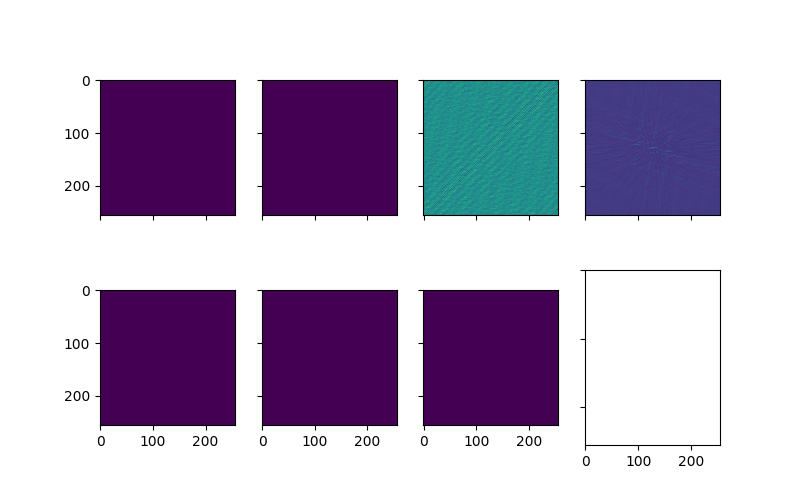

Boxcar max boxcar=0 max=0
Boxcar max boxcar=1 max=0
Boxcar max boxcar=2 max=5
Boxcar max boxcar=3 max=336
Boxcar max boxcar=4 max=0
Boxcar max boxcar=5 max=0
Boxcar max boxcar=6 max=0


In [24]:
fig, ax = subplots(2,4, sharex=True, sharey=True)
fig.set_size_inches(8,5)
ax = ax.flatten()
for b, myax in zip(range(p.boxcar_history.shape[1]), ax):
    d = p.boxcar_history.nparr[dm, b, :, :]
    print(f'Boxcar max boxcar={b} max={d.max()}')
    myax.imshow(np.fft.fftshift(d))

<IPython.core.display.Javascript object>


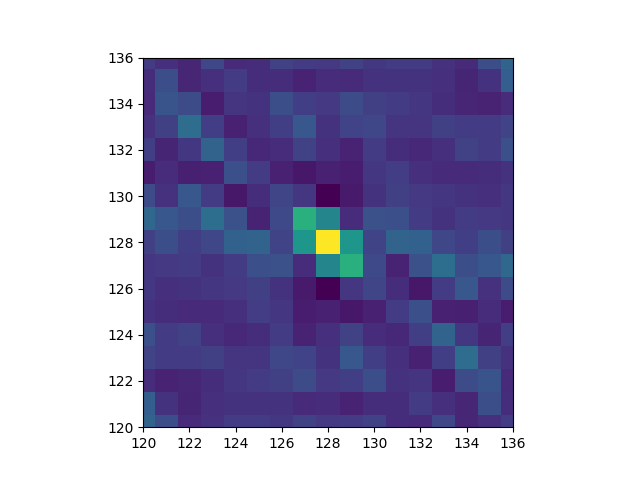

(120.0, 136.0)

In [25]:
figure()
imshow(np.fft.fftshift(p.boxcar_history.nparr[dm,3,:,:]))
xlim(128-8,128+8)
ylim(128-8,128+8)

In [26]:
scale = p.boxcar_history.nparr.max() / mainbuf.sum()
print(f'scale={scale} {1/scale}')

scale=0.0009321732954545455 1072.7619047619048


# with FFT scale = 7, the scaling from sum(input) to output is 8. Roughly. Does this make sense?
I.e. the output is 1/8 of the sum of the inputs.
Well, You might think the scaling would be 8*8 for the FFT, reduced bye 128 for the intermediate scaling. The the
remaining scaling must be 4096 = $2^{12}$. Does that make sense? Maybe, but it probably doesn't matter too much.It must be to do with how the top 16 bits are taken in the output. It's a 36 bit number. Only the top 16 bits are kept, so you could say it's dividing by $2^{20}$ - but that's much larger than $2^{12}$


In [27]:
print(values.fft_shift1)
print(values.fft_shift2)

0
0


In [28]:
print(cands)
cands = cands[cands['dm'] == 0] # DM 0 adn 1 are repeated, I think.

[]


<IPython.core.display.Javascript object>


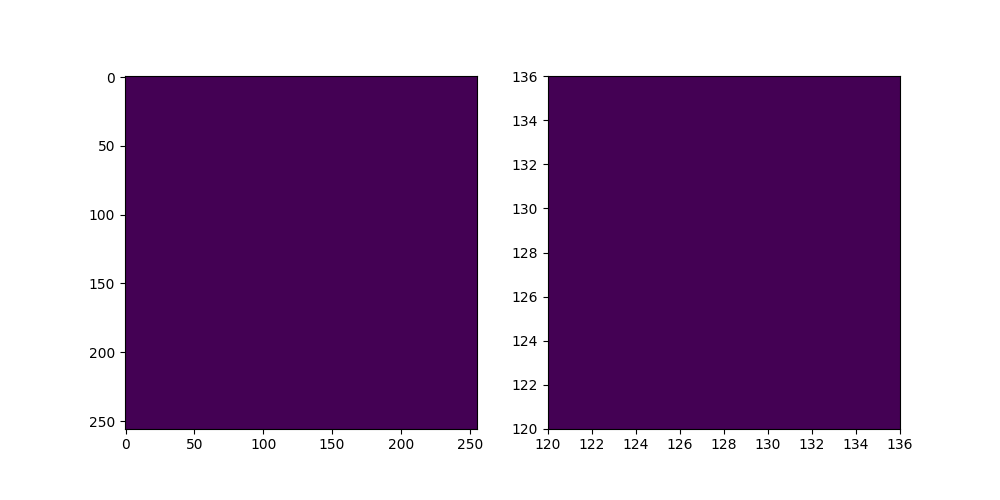

In [29]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

<IPython.core.display.Javascript object>


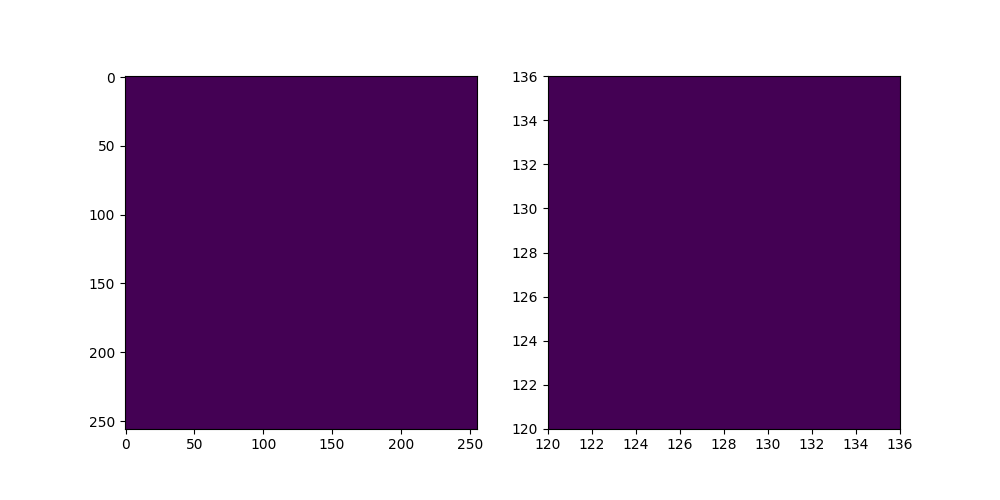

In [30]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

# Check DM0 for trange makes sense

In [31]:
location2pix(0)

(array(128), array(128))

In [32]:
all_cands = []
dm = 0
p.clear_buffers(values)

for t0 in range(16):
    # dmamp = 32 gives SNR=14.2
    dmamp = 32*16
    print('t0', t0)

    # put in a value for a single time and DM
    for b in p.all_mainbufs:
        b.nparr[:] = 0
        b.nparr[:,dm,0,t0,:,0] = dmamp
        b.copy_to_device()

    values.run_fdmt = False
    values.run_image = True
    values.threshold = 5
    p.run(t0, values).wait()    
    cands = p.get_candidates().copy()
    all_cands.append(cands)
    if len(cands) > 0:
        c0 = cands[0]
        print(c0)
        print_candidates(cands, 256, 0)
        centrepix = cands[cands['loc_2dfft'] == 0] # 128, 128
        print_candidates(centrepix, 256,0)
    

    

INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


t0 0


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=1352 nparallel_uv=676 nurest=169 load_luts=1 nplane=16384 shift1=0 shift2=0 fft_cfg=40000000 threshold=5 imgnoise=54.49770637375485 bcnoise=13.624426593438713 bcthresh=68.12213296719356=68

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


(168, 0, 0, 0, 0)
# SNR	lpix	mpix	boxc_width	time	dm	iblk	rawsn



TypeError: cand2str() missing 1 required positional argument: 'raw_noise_level'

In [ ]:
for c in all_cands:
    print_candidates(c, 256, 0)

# FDMT the input of DM=0

In [ ]:
all_cands = []
t0 = 0
print(p.inbuf.shape)

values.run_fdmt = True
values.run_image = True
values.threshold = 10
p.clear_buffers(values)
p.inbuf.nparr[:,:,:,:,0] = 1
p.inbuf.copy_to_device()



In [ ]:

print('t0', t0)
nruns = 5 # make this just 1 if you want to see what happens when you start at 0 in the first block
for irun in range(nruns):
    p.run(irun, values).wait()
cands = p.get_candidates().copy()
print('Got candidates', len(cands))


In [ ]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
mainbuf = p.copy_mainbuf()

In [ ]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
figure()
imshow(d, aspect='auto', origin='lower')
xlabel('time')
ylabel('dm')
printstats(d)
figure()
plot(d.T)
xlabel('Sample')
ylabel('amplitude')
figure()
plot(d.T[:,-1])
xlabel('iDM')
ylabel('Amplitude at last sample')

OK, Banister. For the first 50 or so DMs, you should have the same amplitude because there shouldn't be any smearing at all. I.e. DM=1 should be DM=0 for all values after t=1.

In [ ]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)
figure()
imshow(d.T, aspect='auto', origin='lower')
xlabel('UV')
ylabel('Time')

In [ ]:
print(dir(plan))
figure()
plot(d[:plan.fdmt_plan.nuvtotal, 0])
 # Oh yeah, OK, this makes sense. It's 32 for all baselines because I made every UV = 1. IN practice, it won't be that neat.

In [ ]:
bch = p.boxcar_history.copy_from_device()
bch.shape

In [ ]:
fig, ax = subplots(2,4, sharex=True, sharey=True)
fig.set_size_inches(8,5)
ax = ax.flatten()
for b, myax in zip(range(p.boxcar_history.shape[1]), ax):
    d = p.boxcar_history.nparr[dm, b, :, :]
    print(f'Boxcar max boxcar={b} max={d.max()}')
    myax.imshow(np.fft.fftshift(d))

In [ ]:
bch.shape

In [ ]:
figure()
plot(p.boxcar_history.nparr[:, :, 0,0])
xlabel('DM')
ylabel('Phase center amplitude')
xlim(0,511)

In [ ]:
cell0 = p.plan.fdmt_plan.fdmt_runs[0][0]
cell0

In [ ]:
p.plan.fdmt_plan.pipeline_plan.foff

In [ ]:
p.plan.fdmt_plan.fdmt_lut.shape

In [ ]:
p.plan.fdmt_plan.fdmt_lut[0,:,0,:]/(1<<16)

In [ ]:
from craft import fdmt
self = p.plan.fdmt_plan
fch1 = self.run_fch1[0]
ncin = self.pipeline_plan.ncin
ndout = self.pipeline_plan.ndout
thefdmt_corr = fdmt.Fdmt(fch1-self.pipeline_plan.foff/2.0, self.pipeline_plan.foff, ncin, ndout, 1, do_correction=True) 
thefdmt_ncorr = fdmt.Fdmt(fch1-self.pipeline_plan.foff/2.0, self.pipeline_plan.foff, ncin, ndout, 1, do_correction=False) 

In [ ]:
thefdmt_corr.calc_lookup_table()

In [ ]:
thefdmt_ncorr.calc_lookup_table()

In [ ]:
ndout

In [ ]:
fig,ax = subplots(1,2)
ax[0].imshow(thefdmt_corr.add_frb_track(42))
ax[0].set_xlabel('sample')
ax[0].set_ylabel('Channel')
ax[0].set_title('Corrected')
ax[1].imshow(thefdmt_ncorr.add_frb_track(42))
ax[1].set_xlabel('sample')
ax[1].set_title('Uncorrected')

xlabel('Channel')
xlabel('sample')

In [ ]:
sigma_corr = [thefdmt_corr.get_eff_sigma(idm,1) for idm in range(ndout)]
sigma_ncorr = [thefdmt_ncorr.get_eff_sigma(idm,1) for idm in range(ndout)]
figure()
plot(sigma_corr, label='Corrected')
plot(sigma_ncorr, label='Uncorrected')
xlabel('IDM')
ylabel('Effective sigma')
legend()

# And what if I grid everything properly - i.e. start with baslines,the convert to UV then run the pipeline

In [ ]:
print(plan.baseline_shape) # nbl, nc, nt


In [ ]:

values.input_scale = 1 # need this otherwise somewhere candidates overflow.
signal = 16*3
noise = 1024
din = np.zeros(plan.baseline_shape, dtype=np.complex64)

snincrease = np.sqrt(plan.nf * plan.nbl)
if noise == 0:
    sovern = 100
else:
    sovern = signal/noise

expectedsn = sovern*snincrease

    
din[:, :, -1] += signal # making this 32 overflows the FDMT
din += noise*(np.random.randn(din.size).reshape(din.shape) + 1j*np.random.randn(din.size).reshape(din.shape))
img_noise_level = noise*snincrease/(1<<10)#/np.sqrt(2) # Sum of real and imaginary?
img_signal_level = signal*plan.nf*plan.nbl/(1<<10)
print(f'SN per baseline is num things is {plan.nf*plan.nbl} {signal}/{noise}={sovern} snincrease={snincrease} expected S/N={expectedsn} din.real.std={din.real.std()} imgnoise level={img_noise_level} signal level={img_signal_level}')

# noise = 64 I get 1600 as teh std of the boxcar

In [ ]:
values.fft_shift1 = 0 # dividing
values.fft_shift2 = 0 # multiplying
values.run_fdmt = True
values.run_image = True
values.threshold = 10
p.clear_buffers(values)
p.copy_input(din, values)
p.run(0, values).wait()



p.boxcar_history.copy_from_device()
maxbc = p.boxcar_history.nparr.max()
actual_noise = p.boxcar_history.nparr[0,1:,::4,::4].std(axis=0).mean()
actual_noise2 = p.boxcar_history.nparr[0,1:,0,0].std(axis=0)
actual_signal=p.boxcar_history.nparr[0,0,0,0]
actualsn = actual_signal/actual_noise
actualsn2 = actual_signal/actual_noise2
print(f'Input S={signal} N={noise} Found S/N={actualsn:0.1f} v2={actualsn2:0.1f} expected={expectedsn:0.1f} noise={actual_noise} noise2={actual_noise2} signal={actual_signal}')
print(f'Expected noise ratio noise1={actual_noise/img_noise_level:0.3f} noise2={actual_noise2/img_noise_level:0.3f} signal={img_signal_level/actual_signal:0.3f}')
print(printstats(p.boxcar_history.nparr[0,...]))

cands = p.get_candidates()
print_candidates(cands[:6], 256, 0)


In [ ]:
inbuf = p.inbuf.copy_from_device().nparr 
inbuf.shape

In [ ]:
inbuf = np.transpose(inbuf, [0,3,1,2,4]).reshape(-1,256,32,2)
inbuf.shape

In [ ]:
t0 = inbuf[:,-1,:,:]
print(f'inbuf real={t0[:,:,0].sum()}/{t0[:,:,0].std()} imag={t0[:,:,1].mean()}/{t0[:,:,1].std()} ')

In [ ]:
print_candidates(cands, 256, 0)


In [ ]:
figure()
p.boxcar_history.shape
plot(p.boxcar_history.nparr[0,:,0,0])

In [ ]:
bch = p.boxcar_history.nparr
bch.std()

In [ ]:
bch[0,1:,0,0].std()

In [ ]:
bch[0,:,0,0].max()

In [ ]:
bch[0,:,0,0].max()/bch[0,1:,0,0].std()

In [ ]:
bch[0,1:,:,:].std()

In [ ]:
print(printstats(bch[0,...].std(axis=0)))

din.real.std()

In [ ]:
snr = bch[0,0,:,:]
figure()
imshow(np.fft.fftshift(snr))
print(printstats(snr))
y = 128
x=128
xlim(x-8,x+8)
ylim(y-8,y+8)

In [ ]:
_ = hist(snr.flatten(), bins=100)

In [ ]:
check_mainbuf = True
if check_mainbuf:
    mainbuf = p.copy_mainbuf()
    print(mainbuf.shape)
    # look at the DM-time plan for UV 0
    d = mainbuf[0,:,0,:,0,0]
    imshow(d, aspect='auto', origin='lower')
    printstats(d)
    
    # look at DM=0 for all UVs
    d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
    print(d.shape)
    d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
    print(d.shape)
    figure()
    imshow(d.T, aspect='auto', origin='lower')

In [ ]:
mainbuf.shape

In [ ]:
mainbuf[:,0,0,:,:,0].sum()

In [ ]:
idm = 0
# complex image was boxcar0 + boxcar1
complexim = np.fft.fftshift(bch[idm, 0, :, :] + 1j*bch[idm,1,:,:])
uvplane = np.fft.ifft2(complexim)
fig, ax = subplots(1,3)
ax[0].imshow(abs(uvplane))
ax[1].imshow(complexim.real)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
ax[2].imshow(complexim.imag)
ax[2].set_xlim(128-8,128+8)
ax[2].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])
ax[0].set_title('abs(uvplane)')
ax[1].set_title('real(image)')
ax[2].set_title('imag(image)')


In [ ]:
idm = 0
# complex image was boxcar0 + boxcar1
complexim = np.fft.fftshift(bch[idm, 0, :, :] + 1j*bch[idm,1,:,:]*0)
uvplane2 = np.fft.ifft2(complexim)
fig, ax = subplots(1,4)
ax[0].imshow(abs(uvplane))
ax[1].imshow(complexim.real)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
ax[2].imshow(complexim.imag)
ax[2].set_xlim(128-8,128+8)
ax[2].set_ylim(128-8,128+8)
ax[3].imshow(abs(uvplane-uvplane2))
fig.set_size_inches([10,5])
ax[0].set_title('abs(uvplane)')
ax[1].set_title('real(image)')
ax[2].set_title('imag(image)')

In [ ]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
bch.shape

In [ ]:
figure()
imshow(bch[:16,:,0,0], aspect='auto', origin='lower')
xlabel('Sample')
ylabel('IDM')
figure()
plot(bch[:16,:,0,0].T)
xlabel('Sample')


# How about pulse with Nonzero DM?

In [ ]:
from craft import simfrb

In [ ]:
dm = 100
toff = 10
tsamp = 1.7
frb = simfrb.mkfrb_fdmt(plan.fmin/1e9, plan.foff/1e9, plan.nf, tsamp, dm, toffset=toff, ntimes=plan.nt)

In [ ]:
imshow(frb.T, aspect='auto', origin='lower', interpolation='none')
xlim(50,100)

In [ ]:
din[:] = 0
print(din.shape, frb.shape)
din[:] = frb.T
fast_baseline2uv(din, uv_out)
assert din.sum() == uv_out.sum(), 'baseline2uv didnt conserve energy'

In [ ]:
imshow(din[0,:,:].real, origin='lower')

In [ ]:
plot(uv_out.sum(axis=1).sum(axis=1).real)

In [ ]:
print(uv_out.shape, uv_out.sum(), din.sum())
imshow(uv_out[1,:,:,0].real.T, aspect='auto', origin='lower')

In [ ]:
# This one seems to hang when together with the 3 cells below. Let's space it out.
p.clear_buffers(values)


In [ ]:

p.inbuf.nparr[:,:,:,:,0] = np.round(uv_out[:,:,:,:].real*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.nparr[:,:,:,:,1] = np.round(uv_out[:,:,:,:].imag*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.copy_to_device()
values.run_fdmt = True
values.run_image = True
values.threshold = 10


In [ ]:
p.run(0, values).wait()

In [ ]:
cands = p.get_candidates()
print_candidates(cands, 256, 0)

In [ ]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
mainbuf = p.copy_mainbuf()

In [ ]:
print(mainbuf.shape)
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)

In [ ]:
!ls *mainbuf*

In [ ]:
mb = []
for b in range(8):
    mb.append(np.load(f'mainbuf_after_run_iblk0_ib{b}.npy'))
    
nb = np.array(mb)

In [ ]:
nb.shape

In [ ]:
nb.shape = (nb.shape[0]*nb.shape[1], nb.shape[2], nb.shape[3], nb.shape[4],8,2)

In [ ]:
nb.shape

In [ ]:
del nb
del mb

In [ ]:
import scipy
scipy.special.erfc(4.5/sqrt(2))

In [ ]:
1/(256*256*8)

In [ ]:
values.input_scale

In [ ]:
peaks = np.zeros((8,8))
for shift1 in range(8):
    for shift2 in range(8):
        values.fft_shift1 = shift1
        values.fft_shift2 = shift2
        values.run_fdmt = True
        values.run_image = True
        values.threshold = 10
        p.clear_buffers(values)
        p.copy_input(din, values)
        p.run(0, values).wait()

        p.boxcar_history.copy_from_device()
        maxbc = p.boxcar_history.nparr.max()
        actual_noise = p.boxcar_history.nparr[0,1:,:,:].std(axis=0).mean()
        actual_noise2 = p.boxcar_history.nparr[0,1:,0,0].std(axis=0)
        actual_signal=p.boxcar_history.nparr[0,0,0,0]
        actualsn = actual_signal/actual_noise
        actualsn2 = actual_signal/actual_noise2
        print(f'shift1={shift1} shift2={shift2} Input S={signal} N={noise} Found S/N={actualsn:0.1f} v2={actualsn2:0.1f} expected={expectedsn:0.1f} noise={actual_noise} noise2={actual_noise2} signal={actual_signal}')
        print(printstats(p.boxcar_history.nparr[0,...]))
        p.boxcar_history.copy_from_device()
        bch = p.boxcar_history.nparr
        peak = bch[0,:,0,0].max()
        peaks[shift1,shift2] = peak


In [ ]:
figure()
imshow(peaks)
ylabel('shift1')
xlabel('shift2')